In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import signal
from scipy.stats import stats
import os
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GroupKFold
import pickle

In [3]:
os.chdir('C:\\Users\\polet\\Desktop\\FER\\Duboko ucenje\\Detekcija-anomalija\\input')
#os.chdir('/home/ninio/PycharmProjects/Detekcija-anomalija/input')
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


.\mi_scores_dict.pkl
.\mi_scores_sorted.pkl
.\sample_submission.csv
.\temp_X_test.pkl
.\temp_X_train.pkl
.\test.csv
.\train.csv


In [4]:
# UTILITY FUNCTIONS FOR CLEANING DATA FROM FIRST EXERCISE
def reindexData(data_frame):
    machine_name=data_frame['machine_name'].unique()[0]
    new_dates= np.arange(0,data_frame['day'].max()+1,1)
    data_frame=data_frame.set_index('day').reindex(new_dates, copy=True).reset_index()
    data_frame.loc[:,'machine_name']=machine_name
    # data_frame.loc[data_frame.loc[data_frame['label'].isnull()],'label']=0
    return data_frame


def removeAfterLabel(dataset):
    anomalies = dataset[dataset['label'] > 0]
    first_anomaly_day = anomalies.min()['day']
    first_post_anomaly = dataset[(dataset['day']>first_anomaly_day) & (dataset['label']==0)].min()['day']
    return dataset.drop(dataset.loc[dataset['day']>=first_post_anomaly].index)

In [5]:
# IMPORT DATA
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [22]:
# CLEANING DATA
# Remove id - no information
train_data = train_data.drop(columns=["id"])

# Fix negative values - return abs
train_data['total'] = train_data['total'].apply(lambda x: abs(x))
test_data['total'] = test_data['total'].apply(lambda x: abs(x))

# Fix broken > total - swap column values
train_data.loc[(train_data['total']<train_data['broken']), ['total','broken']] = train_data.loc[(train_data['total']<train_data['broken']), ['broken','total']].values
test_data.loc[(test_data['total']<test_data['broken']), ['total','broken']] = test_data.loc[(test_data['total']<test_data['broken']), ['broken','total']].values

# Fix missing days for train data - interpolation
train_data=train_data.groupby(['machine_name'], as_index=False).apply(reindexData).reset_index(drop=True)
train_data.interpolate(method="linear", inplace=True)
train_data = train_data.astype({'total':'int', "label":'int', 'broken':'int'})

# Remove unwanted samples after anomaly for train
train_data=train_data.groupby(['machine_name']).apply(removeAfterLabel).reset_index(drop=True)

X_train = train_data.copy()
X_test = test_data.copy()

In [6]:
train_data.head()

,day,broken,total,label,machine_name,id
0,0,14,1467,0,AI10095,0
1,1,12,1866,0,AI10095,1
2,2,31,1586,0,AI10095,2
3,3,0,2020,0,AI10095,3
4,4,12,1588,0,AI10095,4


In [24]:
test_data.head()

,id,machine_name,day,broken,total
0,0,AI10042,0,0,1413
1,1,AI10042,1,3,1546
2,2,AI10042,2,0,1608
3,3,AI10042,3,6,1682
4,4,AI10042,4,0,985


In [25]:
# daily_broken_rate
X_train['daily_broken_rate'] = X_train['broken'] / X_train['day']
X_test['daily_broken_rate'] = X_test['broken'] / X_test['day']

# broken_rate
X_train['broken_rate'] = X_train['broken'] / X_train['total']
X_test['broken_rate'] = X_test['broken'] / X_test['total']

# broken_variance
X_train['broken_variance'] = X_train['broken'].rolling(window=5).var()
X_test['broken_variance'] = X_test['broken'].rolling(window=5).var()

# daily_broken_rate_variance
X_train['daily_broken_rate_variance'] = X_train['daily_broken_rate'].rolling(window=5).var()
X_test['daily_broken_rate_variance'] = X_test['daily_broken_rate'].rolling(window=5).var()

# broken_mean
X_train['broken_mean'] = X_train['broken'].rolling(window=5).mean()
X_test['broken_mean'] = X_test['broken'].rolling(window=5).mean()

# daily_broken_rate_mean
X_train['daily_broken_rate_mean'] = X_train['daily_broken_rate'].rolling(window=5).mean()
X_test['daily_broken_rate_mean'] = X_test['daily_broken_rate'].rolling(window=5).mean()

# broken_std
X_train['broken_std'] = X_train['broken'].rolling(window=5).std()
X_test['broken_std'] = X_test['broken'].rolling(window=5).std()

# daily_broken_rate_skew
X_train['daily_broken_rate_skew'] = X_train['daily_broken_rate'].rolling(window=5).apply(lambda x: stats.skew(x))
X_test['daily_broken_rate_skew'] = X_test['daily_broken_rate'].rolling(window=5).apply(lambda x: stats.skew(x))

# broken_kurtosis
X_train['broken_kurtosis'] = X_train['broken'].rolling(window=5).apply(lambda x: stats.kurtosis(x))
X_test['broken_kurtosis'] = X_test['broken'].rolling(window=5).apply(lambda x: stats.kurtosis(x))

# daily_broken_rate_kurtosis
X_train['daily_broken_rate_kurtosis'] = X_train['daily_broken_rate'].rolling(window=5).apply(lambda x: stats.kurtosis(x))
X_test['daily_broken_rate_kurtosis'] = X_test['daily_broken_rate'].rolling(window=5).apply(lambda x: stats.kurtosis(x))

# daily_broken_rate_expanding_mean
X_train['daily_broken_rate_expanding_mean'] = X_train['daily_broken_rate'].expanding().mean()
X_test['daily_broken_rate_expanding_mean'] = X_test['daily_broken_rate'].expanding().mean()

# broken_rate_expanding_mean
X_train['broken_rate_expanding_mean'] = X_train['broken_rate'].expanding().mean()
X_test['broken_rate_expanding_mean'] = X_test['broken_rate'].expanding().mean()

# Features with rolling window size 15
# broken_mean_15
X_train['broken_mean_15'] = X_train['broken'].rolling(window=15).mean()
X_test['broken_mean_15'] = X_test['broken'].rolling(window=15).mean()

# daily_broken_rate_mean_15
X_train['daily_broken_rate_mean_15'] = X_train['daily_broken_rate'].rolling(window=15).mean()
X_test['daily_broken_rate_mean_15'] = X_test['daily_broken_rate'].rolling(window=15).mean()

# broken_std_15
X_train['broken_std_15'] = X_train['broken'].rolling(window=15).std()
X_test['broken_std_15'] = X_test['broken'].rolling(window=15).std()

# daily_broken_rate_skew_15
X_train['daily_broken_rate_skew_15'] = X_train['daily_broken_rate'].rolling(window=15).apply(lambda x: stats.skew(x))
X_test['daily_broken_rate_skew_15'] = X_test['daily_broken_rate'].rolling(window=15).apply(lambda x: stats.skew(x))

# broken_kurtosis_15
X_train['broken_kurtosis_15'] = X_train['broken'].rolling(window=15).apply(lambda x: stats.kurtosis(x))
X_test['broken_kurtosis_15'] = X_test['broken'].rolling(window=15).apply(lambda x: stats.kurtosis(x))

# daily_broken_rate_kurtosis_15
X_train['daily_broken_rate_kurtosis_15'] = X_train['daily_broken_rate'].rolling(window=15).apply(lambda x: stats.kurtosis(x))
X_test['daily_broken_rate_kurtosis_15'] = X_test['daily_broken_rate'].rolling(window=15).apply(lambda x: stats.kurtosis(x))

In [26]:
temp_X_train = X_train.copy()
temp_X_test = X_test.copy()

In [7]:
temp_X_train=temp_X_train.fillna(0)
temp_X_test=temp_X_test.fillna(0)

large_number = 1e12

temp_X_train = temp_X_train.replace([np.inf, -np.inf], large_number)
temp_X_test = temp_X_test.replace([np.inf, -np.inf], large_number)

In [28]:
temp_X_train.to_pickle('temp_X_train.pkl')
temp_X_test.to_pickle('temp_X_test.pkl')

In [8]:
temp_X_test.head()


,id,machine_name,day,broken,total,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,broken_kurtosis,daily_broken_rate_kurtosis,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15
0,0,AI10042,0,0,1413,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,AI10042,1,3,1546,3.0,0.001940,0.0,0.0,0.0,...,0.000000,0.0,3.000000,0.000970,0.0,0.0,0.0,0.0,0.0,0.0
2,2,AI10042,2,0,1608,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,1.500000,0.000647,0.0,0.0,0.0,0.0,0.0,0.0
3,3,AI10042,3,6,1682,2.0,0.003567,0.0,0.0,0.0,...,0.000000,0.0,1.666667,0.001377,0.0,0.0,0.0,0.0,0.0,0.0
4,4,AI10042,4,0,985,0.0,0.000000,7.2,0.0,1.8,...,-0.921875,0.0,1.250000,0.001102,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
temp_dataset = temp_X_train.copy()
y = temp_dataset.pop('label')
X = temp_dataset.drop(columns = ['day', 'machine_name'])

mi_scores = mutual_info_classif(X, y)

# create a dictionary of feature names and their mutual information scores
mi_scores_dict = dict(zip(X.columns, mi_scores))

# sort the features by their mutual information scores in descending order
mi_scores_sorted = sorted(mi_scores_dict.items(), key=lambda x: x[1], reverse=True)

sorted_feature_list = []
# print the sorted feature names and their corresponding mutual information scores
for feat, score in mi_scores_sorted:
    print(f"{feat}: {score}")
    sorted_feature_list.append(feat)

broken_kurtosis: 0.01391823316101548
broken: 0.00999455990103515
daily_broken_rate_expanding_mean: 0.0071012645736853175
broken_mean: 0.006974696685719373
broken_rate_expanding_mean: 0.0055658493504729956
broken_std: 0.005557160309075493
broken_mean_15: 0.005028572473720572
daily_broken_rate_skew: 0.004774768343324243
broken_std_15: 0.004063676350764878
broken_variance: 0.003793729042228744
broken_rate: 0.0028579256865434166
daily_broken_rate_kurtosis: 0.0027435907149914174
broken_kurtosis_15: 0.0024205388318115917
daily_broken_rate_mean: 0.002093122342012199
daily_broken_rate_mean_15: 0.0019431291611387014
daily_broken_rate_skew_15: 0.0016318447186181029
daily_broken_rate_variance: 0.0015310039822398203
daily_broken_rate_kurtosis_15: 0.0011852906075736636
daily_broken_rate: 0.0006974936195324188
total: 0.00019925365521655802


In [11]:

with open('mi_scores_sorted.pkl', 'wb') as f:
    pickle.dump(mi_scores_sorted, f)

with open('mi_scores_dict.pkl', 'wb') as f:
    pickle.dump(mi_scores_dict, f)

In [9]:
with open('mi_scores_sorted.pkl', 'rb') as f:
    mi_scores_sorted1 = pickle.load(f)

with open('mi_scores_dict.pkl', 'rb') as f:
    mi_scores_dict1 = pickle.load(f)


In [3]:
temp_X_train = pd.read_pickle('temp_X_train.pkl')
temp_X_test = pd.read_pickle('temp_X_test.pkl')

In [4]:
temp_X_test.head()

,id,machine_name,day,broken,total,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,broken_kurtosis,daily_broken_rate_kurtosis,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15
0,0,AI10042,0,0,1413,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,AI10042,1,3,1546,3.0,0.001940,0.0,0.0,0.0,...,0.000000,0.0,3.000000,0.000970,0.0,0.0,0.0,0.0,0.0,0.0
2,2,AI10042,2,0,1608,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,1.500000,0.000647,0.0,0.0,0.0,0.0,0.0,0.0
3,3,AI10042,3,6,1682,2.0,0.003567,0.0,0.0,0.0,...,0.000000,0.0,1.666667,0.001377,0.0,0.0,0.0,0.0,0.0,0.0
4,4,AI10042,4,0,985,0.0,0.000000,7.2,0.0,1.8,...,-0.921875,0.0,1.250000,0.001102,0.0,0.0,0.0,0.0,0.0,0.0


1. Data preparation
    Find a machine that has seasonality in the feature total. Plot signals from the selected machine using the function from the first exercise.



In [37]:
df_train = temp_X_train.copy()
df_test = temp_X_test.copy()
df_train['day'] = pd.to_datetime(df_train['day'])
df_train = df_train.sort_values(by='day')
selected_machine = df_train[df_train['machine_name'] == 'CS103864']
selected_machine.head()

,day,broken,total,label,machine_name,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,broken_kurtosis,daily_broken_rate_kurtosis,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15
524883,1970-01-01 00:00:00.000000000,0,286,0,CS103864,0.0,0.0,2.000000e-01,0.0,0.2,...,0.25,0.0,0.04101,0.003495,1.400000,0.0,2.443651,0.0,2.113654,0.0
524884,1970-01-01 00:00:00.000000001,0,260,0,CS103864,0.0,0.0,-4.920544e-10,0.0,0.0,...,-3.00,0.0,0.04101,0.003495,1.400000,0.0,2.443651,0.0,2.113654,0.0
524885,1970-01-01 00:00:00.000000002,0,161,0,CS103864,0.0,0.0,-4.920544e-10,0.0,0.0,...,-3.00,0.0,0.04101,0.003495,1.000000,0.0,2.104417,0.0,6.466701,0.0
524886,1970-01-01 00:00:00.000000003,0,162,0,CS103864,0.0,0.0,-4.920544e-10,0.0,0.0,...,-3.00,0.0,0.04101,0.003495,1.000000,0.0,2.104417,0.0,6.466701,0.0
524887,1970-01-01 00:00:00.000000004,0,23,0,CS103864,0.0,0.0,-4.920544e-10,0.0,0.0,...,-3.00,0.0,0.04101,0.003495,0.933333,0.0,2.120198,0.0,6.542530,0.0


In [40]:
selected_machine = df_train[df_train['machine_name'] == 'CS103777']
selected_machine.head()

,day,broken,total,label,machine_name,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,broken_kurtosis,daily_broken_rate_kurtosis,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15
524355,1970-01-01 00:00:00.000000000,0,318,0,CS103777,0.00,0.000000,0.3,0.0,0.4,...,-1.833333,0.0,0.041043,0.003497,1.066667,0.0,0.798809,0.0,-1.313544,0.0
524356,1970-01-01 00:00:00.000000001,0,320,0,CS103777,0.00,0.000000,0.2,0.0,0.2,...,0.250000,0.0,0.041043,0.003497,0.933333,0.0,0.798809,0.0,-1.313544,0.0
524357,1970-01-01 00:00:00.000000002,1,432,0,CS103777,0.50,0.002315,0.2,0.0,0.2,...,0.250000,0.0,0.041044,0.003497,0.933333,0.0,0.798809,0.0,-1.313544,0.0
524358,1970-01-01 00:00:00.000000003,0,399,0,CS103777,0.00,0.000000,0.2,0.0,0.2,...,0.250000,0.0,0.041044,0.003497,0.800000,0.0,0.774597,0.0,-1.153061,0.0
524359,1970-01-01 00:00:00.000000004,1,547,0,CS103777,0.25,0.001828,0.3,0.0,0.4,...,-1.833333,0.0,0.041045,0.003497,0.733333,0.0,0.703732,0.0,-0.840976,0.0


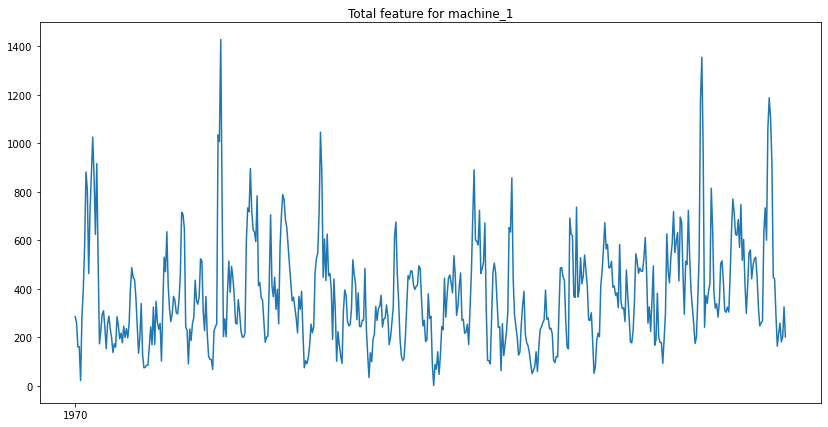

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(selected_machine['day'], selected_machine['total'])
plt.title('Total feature for machine_1')
plt.show()


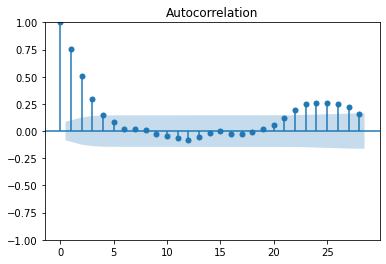

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(selected_machine['total'].dropna())
plt.show()

In the ACF plot, if you see regularly spaced significant spikes, this indicates seasonality.
    In this case, the spikes are not regularly spaced, so there is no seasonality in the signal.

In this case, the spikes are not regularly spaced, so there is no seasonality in the signal.

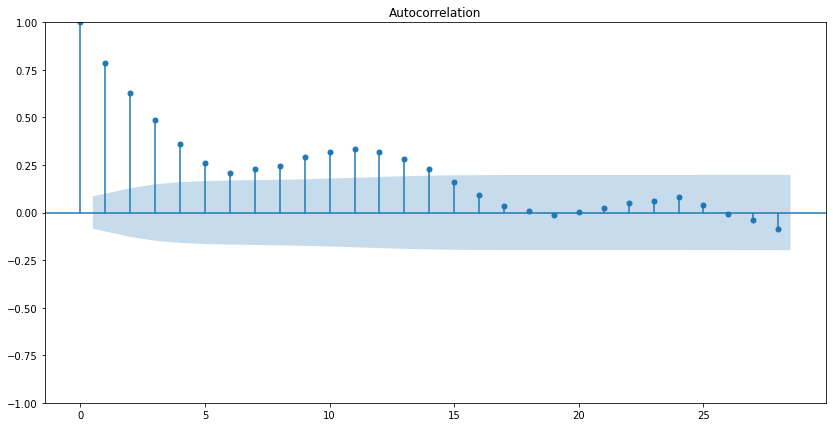

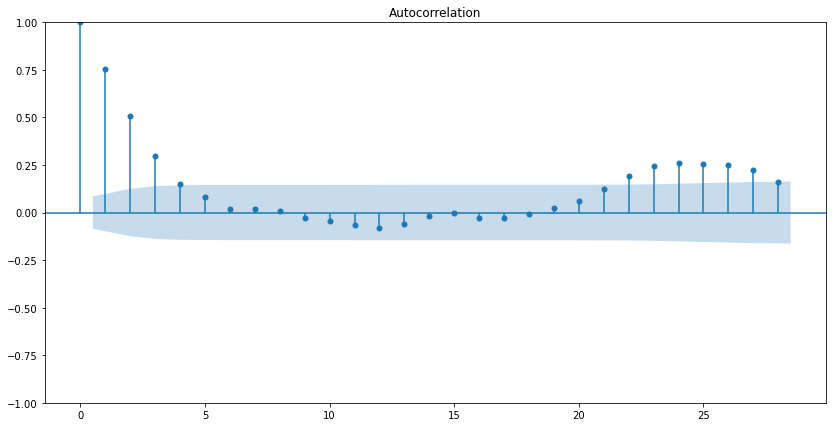

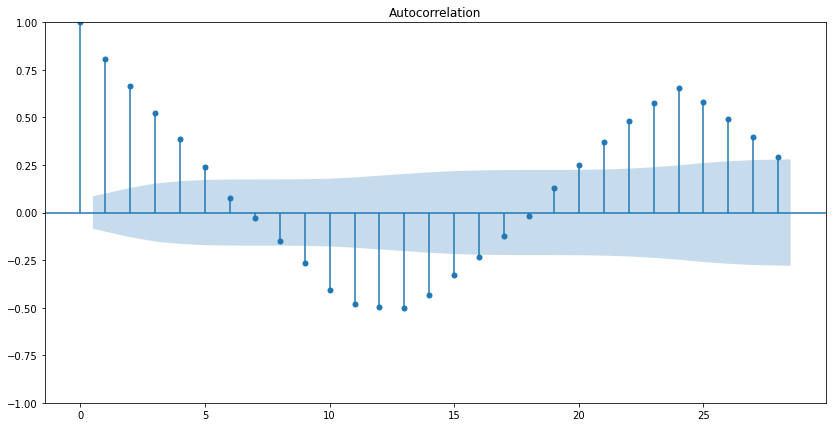

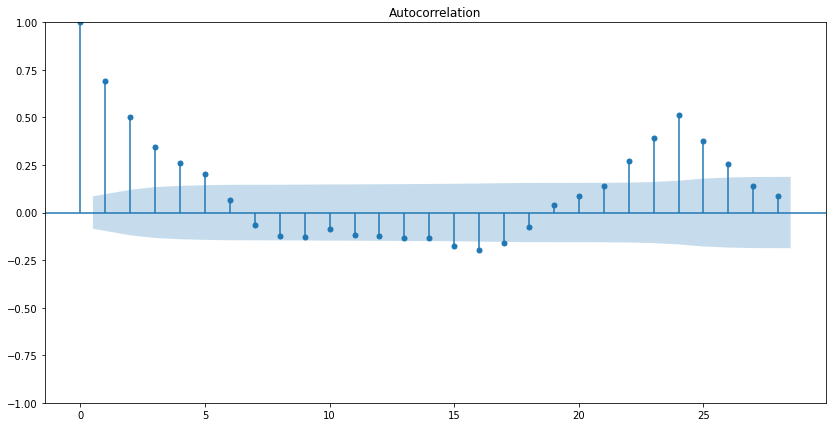

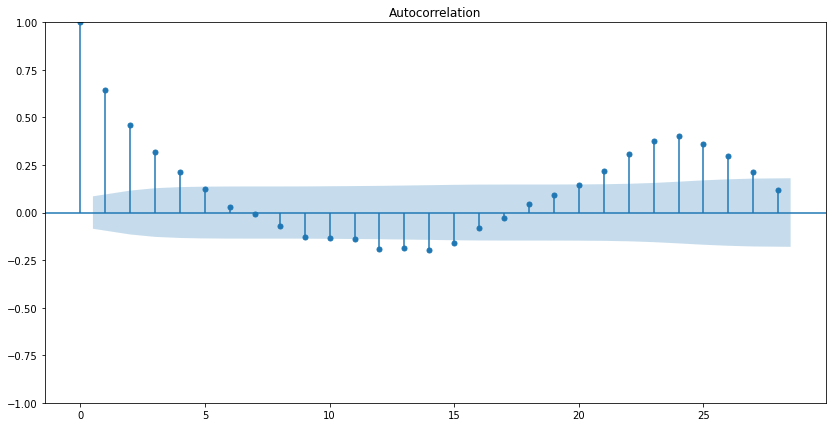

In [43]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Get all unique machine names
machine_names = df_train['machine_name'].unique()

# Loop over each machine
for machine in machine_names[:5]:
    # Select data for this machine
    selected_machine = df_train[df_train['machine_name'] == machine]

    # If there's no data for this machine, continue to the next one
    if selected_machine.empty:
        continue

    # Plot the ACF of the 'total' column for this machine
    plt.figure(figsize=(14,7))
    plt.title(f'Autocorrelation for {machine}')
    plot_acf(selected_machine['total'].dropna(), ax=plt.gca())
    plt.show()


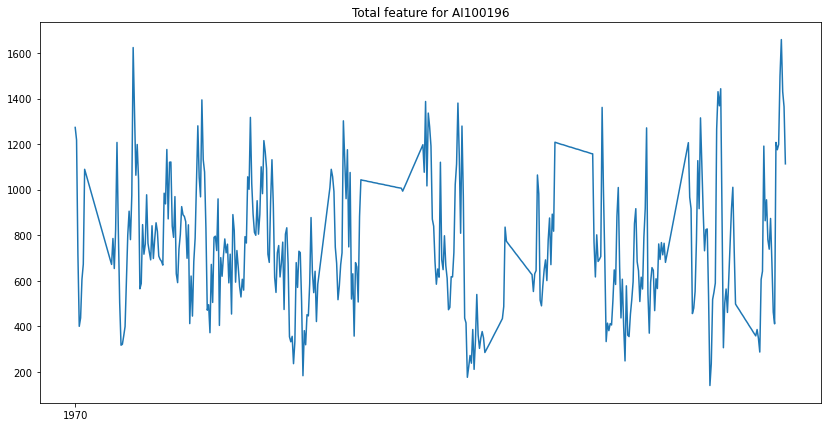

In [44]:
from statsmodels.tsa.stattools import acf

# Prepare to store the max autocorrelation and corresponding machine name
max_acf = -1
max_machine = None

# Loop over each machine
for machine in machine_names:
    # Select data for this machine
    selected_machine = df_train[df_train['machine_name'] == machine]

    # If there's no data for this machine, continue to the next one
    if selected_machine.empty:
        continue

    # Calculate autocorrelation
    machine_acf = acf(selected_machine['total'].dropna())

    # If the max autocorrelation for this machine is higher than the current max, update max_acf and max_machine
    if max(machine_acf) > max_acf:
        max_acf = max(machine_acf)
        max_machine = machine

# Now, max_machine should be the machine with the highest autocorrelation. Plot its data:
selected_machine = df_train[df_train['machine_name'] == max_machine]
plt.figure(figsize=(14,7))
plt.plot(selected_machine['day'], selected_machine['total'])
plt.title(f'Total feature for {max_machine}')
plt.show()


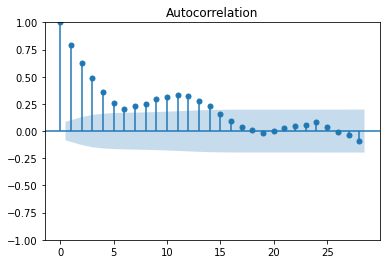

In [45]:
plot_acf(selected_machine['total'].dropna())
plt.show()

In [ ]:
x_values = np.arange(1, len(sorted_feature_list) + 1)
y_values = f1_scores

plt.plot(x_values, y_values)
plt.xlabel('Number of features')
plt.ylabel('F1 score')
plt.show()


2. Exponential smoothing
    Use 70% of the samples as a training set and the rest as a test set. Apply the exponential smoothing method (from statsmodels.tsa.holtwinters import ExponentialSmoothing) on the training set and forecast test set. Calculate the root mean square error and the mean absolute error of your prediction.
    Display a line graph showing the training set, the test set, and the predicted values of the exponential smoothing model. Do you find obtained predictions useful? Why?
    Try some form of parameter optimization to get a more accurate model. Do you manage to improve the model? Show a table of the parameters used and the errors obtained using these parameters.



In [20]:
df = temp_X_train.copy()
y = df['label']

In [26]:
# Split data into train and test
train, test = selected_machine['total'][:int(0.7*len(selected_machine))], selected_machine['total'][int(0.7*len(selected_machine)):]

# Exponential Smoothing
model = ExponentialSmoothing(train, seasonal_periods=12, trend='add')
model_fit = model.fit()
pred = model_fit.predict(start=test.index[0], end=test.index[-1])

# Error calculation
rmse = np.sqrt(mean_squared_error(test, pred))
mae = mean_absolute_error(test, pred)

# Plotting
plt.figure(figsize=(14,7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Exponential Smoothing')
plt.legend(loc='best')
plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

3. ARIMA
    Use 70% of the samples as a training set and the rest as a test set. Apply the ARIMA model (from statsmodels.tsa.arima.model import ARIMA) with predefined parameters (0,0,0) and predict the values of the test set. Calculate the root mean square error and the mean absolute error of your prediction. Display a line graph showing the training set, the test set, and the predicted values of the ARIMA model along with the prediction confidence interval. What does the width of the confidence interval suggest? Do you find obtained prediction useful? Why?
    Try a few different values of the p parameter and leave the other parameters at 0. Can you reduce the error? Display a line prediction graph with the least error. How does the parameter p affect the appearance of the prediction?
    Try a few different values of the q parameter and leave the other parameters at 0. Can you reduce the error? Display a line prediction graph with the least error. How does the q parameter affect the appearance of the prediction?
    Try a few different values of parameter d and leave the other parameters at 0. Can you reduce the error? Display a line prediction graph with the least error. How does parameter d affect the appearance of the prediction?
    Perform the optimization of the parameters p, d and q at the same time and try to reduce the error. Do you manage to significantly improve the model? Display a line graph of the prediction with the least error.
    Try changing the parameter s (seasonality). Do you manage to reduce the error? Display a line prediction graph with the least error. How does the s parameter affect the appearance of the prediction?
    Show a table of the parameters used and the errors obtained using these parameters.



In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('data.csv')

# Make sure your data is in the right format (time series).
# You might need to convert a column to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Assume you're interested in forecasting the 'value' column
# Fit an ARIMA model
model = ARIMA(df['value'], order=(5,1,0)) # Adjust the order parameters (p,d,q) as needed
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot of the original series and the forecasted series
df['forecast'] = model_fit.predict(start=pd.to_datetime('2023-01-01'), end=pd.to_datetime('2023-12-31'), dynamic=True)
df[['value', 'forecast']].plot(figsize=(12, 8))
plt.show()


4. Facebook Prophet
    Prophet (from fbprophet import Prophet) requires as the input set a DataFrame with columns ds and y. y is the value of our time series, and ds is a DateTime column with the moment of that event. Since we do not have information on the exact time, we will assume that the first sample was at timestamp 2018-06-15 00 : 00 : 00, and each subsequent sample was played 24H after the previous one.
    Train the Prophet algorithm on the first 70% of samples and make predictions for the rest of the signal. Using the built-in functions within the fbprophet library, draw a prediction graph and graphs of the individual predictive components of the Prophet algorithm. Calculate the root mean square error and the mean absolute error.
    Manually set the seasonalities observed in the signal (if any) and change their Fourier order parameter values. Do you manage to reduce the error? What prediction does the Prophet algorithm give compared to previously tested algorithms?
    Show a table of the parameters used and the errors obtained using these parameters.



In [ ]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data.csv')

# Convert the column to datetime
df['date'] = pd.to_datetime(df['date'])

# Prophet requires columns ds (Date) and y (value)
df = df.rename(columns={'date': 'ds', 'value': 'y'})

# Make the prophet model and fit on the data
model_prophet = Prophet(daily_seasonality=True) # Enable daily seasonality for daily data, adjust as per the frequency of your data
model_prophet.fit(df)

# Create future dates
future = model_prophet.make_future_dataframe(periods=365) # Forecasting for 1 year from now.

# Predictions
forecast = model_prophet.predict(future)

# Plotting the forecast
model_prophet.plot(forecast)
plt.show()

# You can also view components of your forecast like trend and seasonality
model_prophet.plot_components(forecast)
plt.show()


5. RandomForestRegressor
    Use RandomForestRegressor to predict the total number. Use all features for the regression model. We set aside the first 70% of samples as a training set, and we test the model on the rest of the signal. Using features from the current sample, we predict the value for the feature total in the next sample.
    Train RandomForestRegressor using a training set. Predict the value of the feature total for the test set. Calculate the root mean square error and the mean absolute error. Display a line graph showing the training set, the test set, and the predicted values of the regression model. What are the results compared to those obtained by previously tested algorithms?



In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('data.csv')

# Convert the column to datetime and set it as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Create lagged dataset
def create_lagged_dataset(df, lag=1):
    df_lagged = pd.concat([df.shift(i) for i in range(lag+1)], axis=1)
    df_lagged.fillna(0, inplace=True)
    df_lagged.columns = ['lag_' + str(i) for i in range(lag+1)]
    return df_lagged

lag = 3  # you can adjust this value
df_lagged = create_lagged_dataset(df, lag)

# Split the data into training and test sets
train_size = int(len(df_lagged) * 0.8)
train, test = df_lagged[0:train_size], df_lagged[train_size:len(df_lagged)]

train_X, train_y = train.drop('lag_0', axis=1), train['lag_0']
test_X, test_y = test.drop('lag_0', axis=1), test['lag_0']

# Create the model and fit the data
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(train_X, train_y)

# Make predictions
predictions = model_rf.predict(test_X)

# Check the mean squared error
mse = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % mse)

# Plotting
plt.plot(test_y.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


6.  Generated signal
    Use the code written below to generate a synthetic signal. Display the entire signal. What components does the generated signal consist of? Is there a signal periodicity? If yes, what is the period of periodicity and visualize the part of the signal where it can be seen. Is there a trend in the signal? If yes, what is it like?
    Repeat the assignments for exponential smoothing, ARIMA and Prophet using the signal generated this way.

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Temperature(Min)'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))